This Python Notebook is by Victoria Foing and uses the software packages exoplanet, celerite, pymc3, and starry.</br >
Part of the code is based on the following tutorials from exoplanet:<br />
1) Gaussian process models for stellar variability (https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/)<br />
2) Fitting TESS data (https://exoplanet.readthedocs.io/en/v0.1.6/tutorials/tess/)<br />
3) Quick fits for TESS light curves (https://gallery.exoplanet.codes/en/latest/tutorials/quick-tess/)

# Installing Dependencies

1) Run the cell below<br />
2) Select "Restart runtime" in the top menu (under Runtime)<br />
3) Run the cell below again

In [ ]:
!pip install pandas==0.23.4
import pandas as pd

import numpy as np

!pip install lightkurve
import lightkurve as lk

import matplotlib.pyplot as plt
%matplotlib inline

!pip install exoplanet==0.3.3
import exoplanet as xo

import pymc3 as pm

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

import theano.tensor as tt

!pip install corner
import corner  # https://corner.readthedocs.io

!pip install emcee
import emcee

from astropy.timeseries import BoxLeastSquares
import astropy.units as u

import pickle

from IPython.display import display

from astropy.io import fits
from astropy.stats import sigma_clip
!pip install transitleastsquares

from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )

!pip install python-docx
from docx import Document
from docx.shared import Inches
import matplotlib.pyplot as plt
import numpy as np
from pandas.compat import BytesIO

import warnings
warnings.simplefilter('ignore')

# Helper Functions

These are helper functions for:
*   Preprocessing the lightcurves (correcting, binning, normalizing, stitching)
*   Getting the initial estimates (BLS, TLS, LS Periodogram, ACF)
*   Plotting model results with tables and figures
*   Calculating statistics based on MCMC samples (mean, quantiles)


In [ ]:
# Download all data for a star
def download_all(target_id, mission):

    if mission == "TESS":
        tpf_2mins = lk.search_targetpixelfile(target_id, mission="TESS").download_all()
        lcfs = lk.search_lightcurvefile(target_id, mission="TESS").download_all()

    elif mission == "Kepler":
        tpf_2mins = []
        lcfs = lk.search_lightcurvefile(target_id, mission="Kepler").download_all()

    print(lcfs)

    return tpf_2mins, lcfs

# Download selected data for a star
def download_selected(target_id, mission, selected):

    tpf_2mins = []
    lcfs = []

    for s in selected:
        if mission == "TESS":
            tpf_2min = lk.search_targetpixelfile(target_id, mission="TESS", sector=s).download()
            lcf = lk.search_lightcurvefile(target_id, mission="TESS", sector=s).download()
            tpf_2mins.append(tpf_2min)
            lcfs.append(lcf)
        elif mission == "Kepler":
            tpf_2min = lk.search_targetpixelfile(target_id, mission="Kepler", quarter=s).download()
            lcf = lk.search_lightcurvefile(target_id, mission="Kepler", quarter=s).download()
            tpf_2mins.append(tpf_2min)
            lcfs.append(lcf)

    return tpf_2mins, lcfs

# Remove missing values from target pixel file
def remove_all_nans(self, tpf):
    
    test = np.isnan(self.flux_err)
    self = self[~np.isnan(self.flux)]
    self = self[~np.isnan(self.flux_err)]
    self = self[~np.isnan(self.time)]
    
    tpf = tpf[~test]

    return self, tpf

# Apply Regression Correction to lightcurve
def make_reg_corrections(tpf_2min):

    # Extract lightcurve from target pixel file
    aper = tpf_2min.pipeline_mask
    raw_lc = tpf_2min.to_lightcurve()
    raw_lc, tpf_2min = remove_all_nans(raw_lc, tpf_2min)

    # Make a design matrix
    dm = lk.DesignMatrix(tpf_2min.flux[:, ~aper], name='pixels').pca(5).append_constant()

    # Apply Regression Correction
    reg = lk.RegressionCorrector(raw_lc)
    lc_reg = reg.correct(dm)

    return lc_reg

# Apply PLD Correction to lightcurve
def make_pld_corrections(tpf_2min):

    # Obtain lightcurve from target pixel file
    aper = tpf_2min.pipeline_mask
    raw_lc = tpf_2min.to_lightcurve()
    raw_lc, tpf_2min = remove_all_nans(raw_lc, tpf_2min)
    
    # Apply PLD Correction
    pld = lk.TessPLDCorrector(tpf_2min)
    lc_pld = pld.correct()

    return lc_pld

# Stitch sectors of data together for a star
# Apply preprocessing (binning, correcting, normalizing)
def stitch_lightcurves(lcfs, tpf_2mins, bins=None, corr="sap"):

    time = []
    flux = []
    flux_err = []

    for i,lcf in enumerate(lcfs):

      # Apply corrections
      if corr == "sap":
        corrected = lcf.SAP_FLUX.remove_nans()
      elif corr == "pdcsap":
        corrected = lcf.PDCSAP_FLUX.remove_nans()
      elif corr == "reg":
        corrected = make_reg_corrections(tpf_2mins[i])
      elif corr == "pld":
        corrected = make_pld_corrections(tpf_2mins[i])

      # Bin lightcurve
      if bins:
          corrected = corrected.bin(binsize=bins)

      # Normalize lightcurve
      time = np.concatenate((time,corrected.time))
      norm_flux = (corrected.flux / np.median(corrected.flux) - 1) * 1e3
      flux = np.concatenate((flux,norm_flux))
      norm_flux_err = corrected.flux_err * 1e3 / np.mean(corrected.flux)
      flux_err = np.concatenate((flux_err,norm_flux_err))

      if i == 0:
        lc = corrected.normalize()
      else:
        lc = lc.append(corrected.normalize())

    return lc, time, flux, flux_err


def get_correct_depth(tls_period, time, flux):

  # Create constrained period grid based on tls_period
  period_grid = np.exp(np.linspace(np.log(tls_period-0.1), np.log(tls_period+0.1), 5000))

  # Apply BLS
  bls = BoxLeastSquares(time, flux)
  bls_power = bls.power(period_grid, 0.01, oversample=20)

  # Save the highest peak as the planet candidate
  index = np.argmax(bls_power.power)

  bls_period = bls_power.period[index]
  bls_t0 = bls_power.transit_time[index]
  bls_depth = bls_power.depth[index]

  print(bls_period, bls_t0, bls_depth)

  return bls_period, bls_t0, bls_depth

# Apply Box Least Squares algorithm to lightcurve to get transit parameters
def BLS(flattened_lc, norm_time, norm_flux, sectors=None):

  # Range of periods to search for
  period_grid = np.exp(np.linspace(np.log(0.1), np.log(50), 50000))

  # Apply BLS to flattened lc
  bls = BoxLeastSquares(flattened_lc.time, flattened_lc.flux)
  bls_power = bls.power(period_grid, 0.01, oversample=20)

  # Save the highest peak as the planet candidate
  index = np.argmax(bls_power.power)

  # Get transit period and time from flattened lc
  bls_period = bls_power.period[index]
  bls_t0 = bls_power.transit_time[index]

  # Apply BLS to normalized lc
  norm_bls = BoxLeastSquares(norm_time, norm_flux)
  norm_bls_power = norm_bls.power(period_grid, 0.01, oversample=20)

  # Get transit depth from normalized lc
  bls_depth = norm_bls_power.depth[index]

  # To store plot in Document
  document.add_heading("Box Least Squares")
  bls_plot = BytesIO()

  fig, axes = plt.subplots(2, 1, figsize=(10, 10))

  # Plot the periodogram
  ax = axes[0]
  ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
  ax.plot(np.log10(bls_power.period), bls_power.power, "k")
  ax.annotate(
      "bls period = {0:.4f} d".format(bls_period)+"\nbls t0 = {0:.4f}".format(bls_t0)+"\nbls depth = {0:.4f}".format(bls_depth),
      (0, 1),
      xycoords="axes fraction",
      xytext=(5, -5),
      textcoords="offset points",
      va="top",
      ha="left",
      fontsize=12,
  )
  ax.set_ylabel("bls power")
  ax.set_yticks([])
  ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
  ax.set_xlabel("log10(period)")

  if sectors:
    ax.set_title(pl_hostname+" ("+target_id+"): BLS for sectors="+str(sectors)+", corr="+corr)
  else:
    ax.set_title(pl_hostname+" ("+target_id+"): BLS for sectors=all, corr="+corr)

  # Plot the folded transit
  ax = axes[1]
  x_fold = (time - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
  m = np.abs(x_fold) < 0.4
  ax.plot(x_fold[m], flux[m], ".k")

  # Overplot the phase binned light curve
  bins = np.linspace(-0.41, 0.41, 32)
  denom, _ = np.histogram(x_fold, bins)
  num, _ = np.histogram(x_fold, bins, weights=flux)
  denom[num == 0] = 1.0
  ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

  ax.set_ylabel("de-trended flux [ppt]")
  ax.set_xlabel("time since transit");

  # Add plot to Document
  plt.savefig(bls_plot)
  document.add_picture(bls_plot,width=Inches(6))
  bls_plot.close()

  return bls_period, bls_t0, bls_depth

# Apply Transit Least Squares algorithm to lightcurve to get transit parameters
def TLS(flattened_lc, time, flux, id_num, sectors=None):

  # Obtain stellar parameters based on target id
  if mission=="TESS":
    ab, mass, mass_min, mass_max, radius, radius_min, radius_max = catalog_info(TIC_ID=id_num)
  elif mission=="Kepler":
    ab, mass, mass_min, mass_max, radius, radius_min, radius_max = catalog_info(KIC_ID=id_num)
  print('Searching with limb-darkening estimates using quadratic LD (a,b)=', ab)
  print(ab, mass, mass_min, mass_max, radius, radius_min, radius_max)

  # Apply Transit Least Squares to flattened lightcurve
  tls_model = transitleastsquares(time, flattened_lc.flux)
  tls_results = tls_model.power(u=ab, period_min=0.1, period_max=50)
  print("tls period:", tls_results.period, "period uncertainty:", tls_results.period_uncertainty, "T0:", tls_results.T0)

  # Apply Box Least Squares to normal lightcurve using period found by TLS
  bls_period, bls_t0, bls_depth = get_correct_depth(tls_results.period, time, flux)

  # For storing plot in Document
  document.add_heading("Transit Least Squares")
  tls_plot = BytesIO()

  # Plot TLS results
  plt.figure(figsize=(10,5))
  ax = plt.gca()
  ax.axvline(tls_results.period, alpha=0.4, lw=3)
  plt.xlim(np.min(tls_results.periods), np.max(tls_results.periods))
  for n in range(2, 10):
      ax.axvline(n*tls_results.period, alpha=0.4, lw=1, linestyle="dashed")
      ax.axvline(tls_results.period / n, alpha=0.4, lw=1, linestyle="dashed")
  ax.annotate(
      "tls period = {0:.4f} d".format(tls_results.period)+"\ntls t0 = {0:.4f}".format(tls_results.T0)+"\nbls period = {0:.4f} d".format(bls_period)+"\nbls t0 = {0:.4f}".format(bls_t0)+"\nbls depth = {0:.4f}".format(bls_depth),
      (0.98, 1),
      xycoords="axes fraction",
      xytext=(5, -5),
      textcoords="offset points",
      va="top",
      ha="right",
      fontsize=12,
  )
  plt.ylabel(r'SDE')
  plt.xlabel('Period (days)')
  plt.plot(tls_results.periods, tls_results.power, color='black', lw=0.5)

  if sectors:
    plt.title(pl_hostname+" ("+target_id+"): TLS for sectors="+str(sectors)+", corr="+corr)
  else:
    plt.title(pl_hostname+" ("+target_id+"): TLS for sectors=all, corr="+corr)

  # Add plot to Document
  plt.savefig(tls_plot)
  document.add_picture(tls_plot,width=Inches(7))
  tls_plot.close()

  return bls_period, bls_t0, bls_depth, tls_results

# Apply LS Periodogram to lightcurve
def ls_periodogram(x, y, sector=None, min_period=1, max_period=100.0, xlim_min=None, xlim_max=None, bls=None):

  results = xo.estimators.lomb_scargle_estimator(
      x, y, max_peaks=20, min_period=min_period, max_period=max_period, samples_per_peak=50
  )

  # Select peak, which represents rotation period estimate
  peak = results["peaks"][0]
  freq, power = results["periodogram"]

  # For storing plot in Document
  document.add_heading("LS Periodogram")
  ls_plot = BytesIO()

  # Plot LS periodogram
  plt.figure(figsize=(10,5))
  plt.annotate(
      "LS period = {0:.4f} d".format(peak["period"])+"\nperiod uncertainty= {0:.4f}".format(peak['period_uncert']),
      (0.98, 0.8),
      xycoords="axes fraction",
      xytext=(5, -5),
      textcoords="offset points",
      va="top",
      ha="right",
      fontsize=12,
  )
  plt.plot(1 / freq, power, "k")
  if bls:
    plt.axvline(bls, color="r", lw=4, alpha=0.3, label="BLS Period")
  plt.axvline(peak["period"], color="k", lw=4, alpha=0.3, label="LS Period")
  if xlim_min != None and xlim_max != None:
    plt.xlim(xlim_min,xlim_max)
  else:
    plt.xlim((1 / freq).min(), (1 / freq).max())
  plt.yticks([])
  plt.xlabel("period [days]")
  plt.ylabel("power");
  if sector:
    plt.title(pl_hostname+" ("+target_id+"): LS Periodogram for sector="+sector+", corr="+corr)
  else:
    plt.title(pl_hostname+" ("+target_id+"): LS Periodogram for sector=all, corr="+corr)
  plt.legend(loc="upper right")

  # Add plot to Document
  plt.savefig(ls_plot)
  document.add_picture(ls_plot,width=Inches(7))
  ls_plot.close()

  return peak["period"]

# Apply Autocorrelation function to lightcurve
def ACF(time, flux, yerr, sectors=None):

    acorr = xo.autocorr_estimator(time,flux,yerr=yerr,min_period=1,max_period=100,oversample=5.0,smooth=2.0,max_peaks=10)

    # Select peak, which represents rotation period estimate
    acf_period = np.nan
    if acorr['peaks']:
      acf_period = acorr['peaks'][0]['period']
    
    print("rot. period:",acf_period)
    
    delta_t = np.median(np.diff(time))

    # One dimensional linear interpolation
    y_interp = np.interp(np.arange(time.min(), time.max(), delta_t), time, flux)
    emp_acorr = emcee.autocorr.function_1d(y_interp) * np.var(y_interp)
    tau = np.arange(len(emp_acorr)) * delta_t
    
    # For storing plot in Document
    document.add_heading("Autocorrelation")
    acf_plot = BytesIO()

    # Plot ACF
    plt.figure(figsize=(10,5))
    plt.annotate(
      "ACF period = {0:.4f} d".format(acf_period),
      (0.98, 0.8),
      xycoords="axes fraction",
      xytext=(5, -5),
      textcoords="offset points",
      va="top",
      ha="right",
      fontsize=12,
    )
    plt.plot(tau, emp_acorr)
    plt.axvline(acf_period, color="k", alpha=0.5, label="ACF Period")
    plt.axvline(2*acf_period, color="k", alpha=0.5)
    plt.axvline(3*acf_period, color="k", alpha=0.5)
    plt.ylabel(r"$\left< k(\tau) \right>$")
    plt.xlabel(r"$\tau$")
    plt.title(pl_hostname+" ("+target_id+"): ACF")
    if sectors:
        plt.title(pl_hostname+" ("+target_id+"): ACF for sectors="+str(sectors)+", corr="+corr)
    else:
        plt.title(pl_hostname+" ("+target_id+"): ACF for sectors=all, corr="+corr)
    plt.legend()

    # Add plot to Document
    plt.savefig(acf_plot)
    document.add_picture(acf_plot,width=Inches(7))
    acf_plot.close()

    return acf_period

def mask_transits(time, flux, tls_results):

    intransit = transit_mask(time, tls_results.period, 2 * tls_results.duration, tls_results.T0)
    flux_ootr = flux[~intransit]

    document.add_heading("Masked Lightcurve")
    masked_lightcurve_plot = BytesIO()

    plt.figure(figsize=(20,5))
    plt.plot(time[~intransit],flux[~intransit])

    # Add plot to Document
    plt.savefig(masked_lightcurve_plot)
    document.add_picture(masked_lightcurve_plot, width=Inches(7))
    masked_lightcurve_plot.close()

    time = time[~intransit]
    flux = flux[~intransit]

    return time, flux

# Plot components of GP model
def plot_GP_model(soln, mask=None, transit=True, rot=True):

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    if rot and not transit:
      fig, axes = plt.subplots(2, 1, figsize=(20, 15), sharex=True)

      # Plot stellar activtiy
      ax = axes[0]
      ax.plot(x[mask], y[mask], "k", label="data")
      gp_mod = soln["gp_pred"] + soln["mean"]
      ax.plot(x[mask], gp_mod, color="C2", label="gp model", linewidth=7.0, alpha=0.5)
      ax.legend(fontsize=10)
      ax.set_ylabel("relative flux")

      # Plot residuals
      ax = axes[1]
      ax.plot(x[mask], y[mask] - gp_mod, "k")
      ax.axhline(0, color="#aaaaaa", lw=1)
      ax.set_ylabel("residuals [ppt]")
      ax.set_xlim(x[mask].min(), x[mask].max())
      ax.set_xlabel("time [days]")

    else:
      fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharex=True)

      # Plot stellar activity
      ax = axes[0]
      ax.plot(x[mask], y[mask], "k", label="data")
      gp_mod = soln["gp_pred"] + soln["mean"]
      ax.plot(x[mask], gp_mod, color="C2", label="gp model", linewidth=7.0, alpha=0.5)
      ax.legend(fontsize=10)
      ax.set_ylabel("relative flux")

      # Plot exoplanet transits
      ax = axes[1]
      ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
      for i, l in enumerate("b"):
          mod = soln["light_curves"][:, i]
          ax.plot(x[mask], mod, label="planet {0}".format(l), linewidth=6.0, alpha=0.5)
      ax.legend(fontsize=10, loc=3)
      ax.set_ylabel("de-trended flux [ppt]")

      # Plot residuals
      ax = axes[2]
      mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
      ax.plot(x[mask], y[mask] - mod, "k")
      ax.axhline(0, color="#aaaaaa", lw=1)
      ax.set_ylabel("residuals [ppt]")
      ax.set_xlim(x[mask].min(), x[mask].max())
      ax.set_xlabel("time [days]")

    return fig

# Display model parameters in table
def display_model_params(model_params, var_names):

    table_data = {}

    for name in var_names:
      if name.startswith("log"):
        new_name = name[3:]
        table_data[new_name] = np.exp(model_params[name])
      else:
        table_data[name] = model_params[name].item()
        if name == "r_pl":
          table_data["r_pl_jup"] = (model_params[name].item() * u.R_sun).to(u.R_jup).value

    params_table = pd.DataFrame(data=table_data, index=[0])
    display(params_table)

    # Add GP parameter values to Document
    document.add_heading("MAP Parameters")
    lines = ""
    for c in params_table.columns:
      lines += c+": "+str(params_table[c].iloc[0].round(4))+"\n"
    para = document.add_paragraph(lines)

def clip_outliers(x, y, map_params0, rot, transit):

  if transit:
    mod = (
        map_params0["gp_pred"]
        + map_params0["mean"]
        + np.sum(map_params0["light_curves"], axis=-1)
    )
  else:
    if rot:
      mod = (
          map_params0["gp_pred"]
          + map_params0["mean"]
      )

  resid = y - mod
  rms = np.sqrt(np.median(resid ** 2))
  mask = np.abs(resid) < 5 * rms

  document.add_heading("Outliers")

  outliers_plot = BytesIO()

  plt.figure(figsize=(10, 5))
  plt.plot(x, resid, "k", label="data")
  plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
  plt.axhline(0, color="#aaaaaa", lw=1)
  plt.ylabel("residuals [ppt]")
  plt.xlabel("time [days]")
  plt.legend(fontsize=12, loc=3)
  plt.xlim(x.min(), x.max());

  plt.savefig(outliers_plot)
  document.add_picture(outliers_plot,width=Inches(7))
  outliers_plot.close()

  return mask

# Get mean and quantiles from samples
def get_statistics(samples, transit=True, rot=True):
  
    param_names = []
    statistics = {}

    for c in samples.columns:
      
      # Calculate mean and quantiles for parameter
      mean = samples[c].mean()
      std = samples[c].std()
      q = np.percentile(samples[c], [16, 50, 84])
      lb = np.diff(q)[0]
      ub = np.diff(q)[1]

      # If sampled from log space, convert param name and value
      param = c
      if param.startswith("log"):
        mean = np.exp(mean)
        std = np.exp(std)
        lb = np.exp(lb)
        ub = np.exp(ub)
        param = c[3:]
      
      # Store parameter names
      if param == 'r_pl':
        param_names.append('r_pl_jup')
      else:
        param_names.append(param)

      # Store statistics
      statistics[param] = round(mean,5)
      statistics[param+" std"] = round(std,5)
      statistics[param+" lb"] = round(lb,5)
      statistics[param+" ub"] = round(ub,5)

    # Add parameter for Jupiter radius
    if transit:
      jup_rad_mean = (statistics['r_pl'] * u.R_sun).to(u.R_jup).value
      jup_rad_std = (statistics['r_pl std'] * u.R_sun).to(u.R_jup).value
      jup_rad_lb = (statistics['r_pl lb'] * u.R_sun).to(u.R_jup).value
      jup_rad_ub = (statistics['r_pl ub'] * u.R_sun).to(u.R_jup).value

      statistics['r_pl_jup'] = round(jup_rad_mean,5)
      statistics['r_pl_jup std'] = round(jup_rad_std,5)
      statistics['r_pl_jup lb'] = round(jup_rad_lb,5)
      statistics['r_pl_jup ub'] = round(jup_rad_ub,5)

    return statistics, param_names

# Display results along side reference values in a table
def results_table(gp_results, ref_results, param_names):

  data = []

  for param in param_names:

    # Get GP value and interval
    gp_value = gp_results[param]
    gp_error = (abs(gp_results[param+" lb"]), abs(gp_results[param+" ub"]))

    # Initialize ref value, error, and name
    ref_value = ""
    ref_error = ""
    ref_name = ""

    # Check if param is in ref table
    if param in ref_results.columns:

      # Set ref value, if it exists
      if np.isfinite(float(ref_results[param].iloc[0])):
        ref_value = float(ref_results[param].iloc[0])

        # Set ref error, if it exists
        if np.isfinite(ref_results[param+" lb"].iloc[0]):
          ref_error = (abs(ref_results[param+" lb"].iloc[0].round(4)), +abs(ref_results[param+" ub"].iloc[0].round(4)))

        # Set ref name
        if param == "rotperiod":
          ref_name = ref_results['prot_refname'].iloc[0]
        elif param in ["m_star","r_star"]:
          ref_name = ref_results['st_refname'].iloc[0]
        else:
          ref_name = ref_results['pl_refname'].iloc[0]

    data.append([param, gp_value, gp_error, ref_value, ref_error, ref_name])

  results = pd.DataFrame(data, columns = ['param','gp_mean','gp_error','ref_mean','ref_error','ref_name'])

  return results

# Plot error bars for parameter
def print_error_bars(results, param, sectors):

  # Get GP results for parameter
  x = [0]
  y = [float(results[results['param']==param]['gp_mean'].iloc[0])]
  lb = [float(results[results['param']==param]['gp_error'].iloc[0][0])]
  ub = [float(results[results['param']==param]['gp_error'].iloc[0][1])]

  # For storing plot in Document
  error_bars_plot = BytesIO()

  # Plot GP results for parameter
  plt.figure(figsize=(7,7))
  plt.errorbar(x, y, [lb,ub], capsize=5, marker='o', ls="None", label="GP model")

  # Get Reference information for parameter
  ref_value = results[results['param']==param]['ref_mean'].iloc[0]
  ref_error = results[results['param']==param]['ref_error'].iloc[0]
  ref_name = results[results['param']==param]['ref_name'].iloc[0]

  # Plot Reference information for parameter
  if ref_value:
      plt.hlines(float(ref_value), min(x)-1, max(x)+1, alpha=0.15, label=ref_name)
      if ref_error:
          plt.fill_between([min(x)-1,max(x)+1], float(ref_value) - float(ref_error[0]), float(ref_value) + float(ref_error[1]), alpha=0.15)
  plt.title(pl_hostname+": MCMC guess "+param, fontsize=25)
  plt.ylabel(param, fontsize=20)
  plt.xlabel("Sectors", fontsize=20)
  plt.xticks(x,sectors)
  plt.legend()

  # Add plot to Document
  plt.savefig(error_bars_plot)
  document.add_picture(error_bars_plot,width=Inches(2))
  error_bars_plot.close()

def get_model_components(trace, mask=None, transit=True, rot=True):
  
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    document.add_heading("Model Components")

    # For storing plot in Document
    model_components_plot = BytesIO()

    if transit:
      fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharex=True)

      ax = axes[0]
      ax.plot(x[mask], y[mask], "k", label="data")

      gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)
      ax.plot(x[mask], gp_mod, color="C2", label="gp model", linewidth=7.0, alpha=0.5)
      ax.legend(fontsize=10)
      ax.set_ylabel("relative flux")

      lc = np.median(np.sum(trace["light_curves"], axis=-1), axis=0)
      ax = axes[1]
      ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
      ax.plot(x[mask], lc, label="planet", linewidth=7.0, alpha=0.5)
      ax.legend(fontsize=10, loc=3)
      ax.set_ylabel("de-trended flux [ppt]")

      ax = axes[2]
      mod = gp_mod + lc
      ax.plot(x[mask], y[mask] - mod, "k")
      ax.axhline(0, color="#aaaaaa", lw=1)
      ax.set_ylabel("residuals [ppt]")
      ax.set_xlim(x[mask].min(), x[mask].max())
      ax.set_xlabel("time [days]")

      model_components = {
        'x': x[mask],
        'y': y[mask],
        'gp_mod': gp_mod,
        'light_curves': lc,
        'residuals': y[mask] - gp_mod - lc
      }
    else:
      if rot:
        fig, axes = plt.subplots(2, 1, figsize=(20, 15), sharex=True)

        ax = axes[0]
        ax.plot(x[mask], y[mask], "k", label="data")

        gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)
        ax.plot(x[mask], gp_mod, color="C2", label="gp model", linewidth=7.0, alpha=0.5)
        ax.legend(fontsize=10)
        ax.set_ylabel("relative flux")

        ax = axes[1]
        ax.plot(x[mask], y[mask] - gp_mod, "k")
        ax.axhline(0, color="#aaaaaa", lw=1)
        ax.set_ylabel("residuals [ppt]")
        ax.set_xlim(x[mask].min(), x[mask].max())
        ax.set_xlabel("time [days]")

        model_components = {
          'x': x[mask],
          'y': y[mask],
          'gp_mod': gp_mod,
          'residuals': y[mask] - gp_mod
        }

    # Add plot to Document
    plt.savefig(model_components_plot)
    document.add_picture(model_components_plot,width=Inches(7))
    model_components_plot.close()

    return model_components

# Select Target and Experimental Settings

**Load target information**

On the left under Files, upload an excel file with information about target stars (i.e. target name, target id, stellar params, planet params).

In [ ]:
# Load the excel file into a pandas dataframe
targets = pd.read_excel('All_Targets.xlsx')
targets.tail()

,hostname,tic_id,kic_id,pl_name,sectors,rot_detected,planet_detected,rot,prot_guess,prot_other,pl_orbper,martins_variability_type,default_flag,sy_snum,sy_pnum,discoverymethod,disc_facility,tran_flag,pl_controv_flag,pl_refname,period,period ub,period lb,period lim,r_pl_earth,r_pl_earth ub,r_pl_earth lb,r_pl_earth lim,r_pl_jup,r_pl_jup ub,r_pl_jup lb,r_pl_jup lim,ecc,ecc ub,ecc lb,ecc lim,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,...,ror lb,ror lim,st_refname,st_spectype,st_teff,st_tefferr1,st_tefferr2,st_tefflim,r_star,r_star ub,r_star lb,r_star lim,m_star,m_star ub,m_star lb,m_star lim,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_age,st_ageerr1,st_ageerr2,st_agelim,st_vsin,st_vsinerr1,st_vsinerr2,st_vsinlim,rotperiod_martins,rotperiod_martins ub,rotperiod_martins lb,martins_variability_type.1,prot_refname,rotperiod,rotperiod ub,rotperiod lb,rotperiod lim,pl_pubdate,releasedate,notes
102,Kepler-423,NaN,KIC 9651668,Kepler-423 b,NaN,NaN,NaN,1.0,NaN,22.05,2.684328,NaN,0,1,1,Transit,Kepler,1,0,Bonomo et al. 2017,2.684328,7.000000e-08,-7.000000e-08,0,13.361,0.583,-0.583,0.0,1.192,0.052,-0.052,0.0,0.0790,NaN,NaN,1.0,87.83,0.13,-0.13,0.0,...,NaN,NaN,Bonomo et al. 2017,NaN,5560.0,80.0,-80.0,0.0,0.95,0.04,-0.04,0,0.85,0.04,-0.04,0,NaN,NaN,NaN,NaN,11.0,2.0,-2.0,0.0,2.5,0.5,-0.5,0.0,NaN,NaN,NaN,NaN,NaN,22.05,0.12,-0.12,0.0,2017-06,2019-03-21,NaN
103,Kepler-43,NaN,KIC 9818381,Kepler-43 b,NaN,NaN,NaN,1.0,NaN,12.95,3.024093,NaN,0,1,1,Transit,Kepler,1,0,Bonomo et al. 2017,3.024093,2.000000e-07,-2.000000e-07,0,13.002,0.448,-0.336,0.0,1.160,0.040,-0.030,0.0,0.0280,NaN,NaN,1.0,84.57,0.18,-0.37,0.0,...,NaN,NaN,Bonomo et al. 2017,NaN,6050.0,100.0,-100.0,0.0,1.38,0.05,-0.03,0,1.27,0.04,-0.04,0,NaN,NaN,NaN,NaN,2.3,0.8,-0.7,0.0,5.5,1.5,-1.5,0.0,NaN,NaN,NaN,NaN,NaN,12.95,0.25,-0.25,0.0,2017-06,2019-03-21,NaN
104,Kepler-45,NaN,KIC 5794240,Kepler-45 b,NaN,NaN,NaN,1.0,NaN,15.80,2.455234,NaN,0,1,1,Transit,Kepler,1,0,Bonomo et al. 2017,2.455234,4.800000e-06,-4.800000e-06,0,10.761,1.233,-1.233,0.0,0.960,0.110,-0.110,0.0,0.2300,NaN,NaN,1.0,87.00,0.70,-0.70,0.0,...,NaN,NaN,Bonomo et al. 2017,NaN,3820.0,90.0,-90.0,0.0,0.55,0.11,-0.11,0,0.59,0.06,-0.06,0,NaN,NaN,NaN,NaN,0.8,0.7,-0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.80,0.20,-0.20,0.0,2017-06,2019-03-21,NaN
105,Kepler-75,NaN,KIC 757450,Kepler-75 b,NaN,NaN,NaN,1.0,NaN,19.18,8.884912,NaN,0,1,1,Transit,Kepler,1,0,Bonomo et al. 2017,8.884912,3.400000e-06,-3.400000e-06,0,11.769,0.336,-0.336,0.0,1.050,0.030,-0.030,0.0,0.5704,0.0093,-0.0094,0.0,89.12,0.51,-0.64,0.0,...,NaN,NaN,Bonomo et al. 2017,NaN,5200.0,100.0,-100.0,0.0,0.89,0.02,-0.02,0,0.91,0.04,-0.04,0,NaN,NaN,NaN,NaN,6.2,3.5,-2.8,0.0,3.5,1.5,-1.5,0.0,NaN,NaN,NaN,NaN,NaN,19.18,0.25,-0.25,0.0,2017-06,2019-03-21,NaN
106,WASP-62,TIC 149603524,NaN,WASP-62 b,"[1-4,6-13]",?,1,NaN,7.55,NaN,4.411950,ambiguous_variability,1,1,1,Transit,SuperWASP,1,0,Stassun et al. 2017,4.411950,3.000000e-06,-3.000000e-06,0,14.796,0.897,-0.897,0.0,1.320,0.080,-0.080,0.0,0.0000,NaN,NaN,0.0,88.30,0.75,-0.75,0.0,...,NaN,NaN,Stassun et al. 2017,NaN,6230.0,80.0,-80.0,0.0,1.23,0.08,-0.08,0,1.11,0.25,-0.25,0,4.45,0.1,-0.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ambiguous_variability,NaN,NaN,NaN,NaN,NaN,2017-03,2018-04-26,NaN


**Select a Target and set Experiment Settings**<br />
The cell below is the most important. It is where we select the target star and set the experimental settings:
*   **Target star**: Select a target star based on its name from the excel file (e.g. "Kepler-17")
*   **Mission**: Select the mission (e.g. "Kepler" or "TESS")
*   **Sectors**: Select the sectors of the lightcurve you want to use and list them in an array. (e.g. [1,2,3,4])
*   **GP model**: Select GP model (e.g. "exorot", "rot", "exo")
    * e.g. "exorot" (Transit + Rotation), "rot" (Rotation), "exo" (Transit)
*   **Binsize**: Select a bin size if you want to bin the data and have fewer datapoints (e.g. 15). NOTE: this usually leads to worse results.
*   **Correction method**: Select the correction method
    * e.g. "sap" (Raw lightcurve), "pdcsap" (Pipeline corrected lightcurve), "reg" (Regression corrected lightcurve - only for TESS)
*   **MCMC conditions**: Select the number of tuning steps, the number of chains, and the number of samples

After setting these conditions, you can automatically run the remaining cells the notebook.<br />

There is also the option of running the cells individually if you want to analyze the star first and then change the settings accordingly.

In [ ]:
# Set target (e.g. target "Kepler-17" which has many sectors of data available)
pl_hostname = "HAT-P-11"

# Set mission (e.g. "TESS" or "Kepler")
mission = "TESS"

# Select the sectors of the lightcurve you want to use and list them in an array. (e.g. [1,2,3,4])
sectors = [14,15]

# Select the binsize
bins = None

# Select GP model (e.g. "exorot", "rot", "exo")
gp_type = "exorot"

# Set correction method (e.g. "pdcsap", "reg", "sap")
corr = "pdcsap"

# Set MCMC conditions
mcmc_tune = 350
mcmc_chains = 2
mcmc_samples = 2000

Get parameters associated with target star

In [ ]:
# Set arguments for rotation and transit based on GP model
if gp_type == "exorot":
  rot = True
  transit = True
elif gp_type == "rot":
  rot = True
  transit = False
elif gp_type == "exo":
  rot = False
  transit = True

if mission == "TESS":
  mission_id = "tic_id"
elif mission == "Kepler":
  mission_id = "kic_id"

# Get star id
target_id = targets[targets['hostname']==pl_hostname][mission_id].iloc[0]

# Set mass and radius of star
M_star = targets[targets[mission_id]==target_id]["m_star"].iloc[0], targets[targets[mission_id]==target_id]["m_star ub"].iloc[0]
R_star = targets[targets[mission_id]==target_id]["r_star"].iloc[0], targets[targets[mission_id]==target_id]["r_star ub"].iloc[0]

display(targets[targets['hostname']==pl_hostname])

,hostname,tic_id,kic_id,pl_name,sectors,rot_detected,planet_detected,rot,prot_guess,prot_other,pl_orbper,martins_variability_type,default_flag,sy_snum,sy_pnum,discoverymethod,disc_facility,tran_flag,pl_controv_flag,pl_refname,period,period ub,period lb,period lim,r_pl_earth,r_pl_earth ub,r_pl_earth lb,r_pl_earth lim,r_pl_jup,r_pl_jup ub,r_pl_jup lb,r_pl_jup lim,ecc,ecc ub,ecc lb,ecc lim,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,...,ror lb,ror lim,st_refname,st_spectype,st_teff,st_tefferr1,st_tefferr2,st_tefflim,r_star,r_star ub,r_star lb,r_star lim,m_star,m_star ub,m_star lb,m_star lim,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_age,st_ageerr1,st_ageerr2,st_agelim,st_vsin,st_vsinerr1,st_vsinerr2,st_vsinlim,rotperiod_martins,rotperiod_martins ub,rotperiod_martins lb,martins_variability_type.1,prot_refname,rotperiod,rotperiod ub,rotperiod lb,rotperiod lim,pl_pubdate,releasedate,notes
8,HAT-P-11,TIC 28230919,KIC 10748390,HAT-P-11 b,"[14,15]",1,1,1.0,NaN,29.2,4.887802,unambiguous_rotation,1,1,2,Transit,HATNet,1,0,Yee et al. 2018,4.887802,NaN,NaN,0,4.36,0.06,-0.06,0.0,0.389,0.005,-0.005,0.0,0.218,0.034,-0.031,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,Yee et al. 2018,NaN,4780.0,50.0,-50.0,0.0,0.68,0.01,-0.01,0,0.81,0.02,-0.03,0,NaN,NaN,NaN,NaN,6.5,5.9,-4.1,0.0,1.5,1.5,-1.5,0.0,10.189,1.104,1.104,unambiguous_rotation,Yee et al. 2018,29.2,NaN,NaN,0.0,2018-06,2019-01-31,NaN


Create the document that will store all the plots and results for the star

In [ ]:
# Create document to store plots
document = Document()
document.add_heading(pl_hostname,0)

info = targets[targets['hostname']==pl_hostname][[mission_id, 'sy_snum', 'sy_pnum', 'st_spectype', 'st_age', 'st_teff', 'rotperiod', 'martins_variability_type', 'period', 'r_pl_jup', 'ecc','b']]

lines = ""
# Add basic info about experimental settings to the document
lines += "bins: "+str(bins)+"\n"
lines += "gp_type: "+gp_type+"\n"
lines += "corr: "+corr+"\n"
lines += "mcmc (tune,chains,samples): "+str(mcmc_tune)+", "+str(mcmc_chains)+", "+str(mcmc_samples) +"\n\n"

# Add basic info about the star to the document
for c in info.columns:
  lines += c+": "+str(info[c].iloc[0])+"\n"

target_info = document.add_paragraph(lines)

# Preprocessing


**Download and stitch all sectors**

Download and stitch all available sectors for the target star. The full lightcurve is not passed to the Gaussian Process model because it usually has too many datapoints, which slows down computation. However, looking at the full lightcurve can be useful for analyzing the star and selecting a good section of data.

LightCurveFileCollection of 14 objects:
	KIC 10619192 (14 KeplerLightCurveFiles) Quarters: 1,2,3,4,5,6,8,9,10,12,13,14,16,17



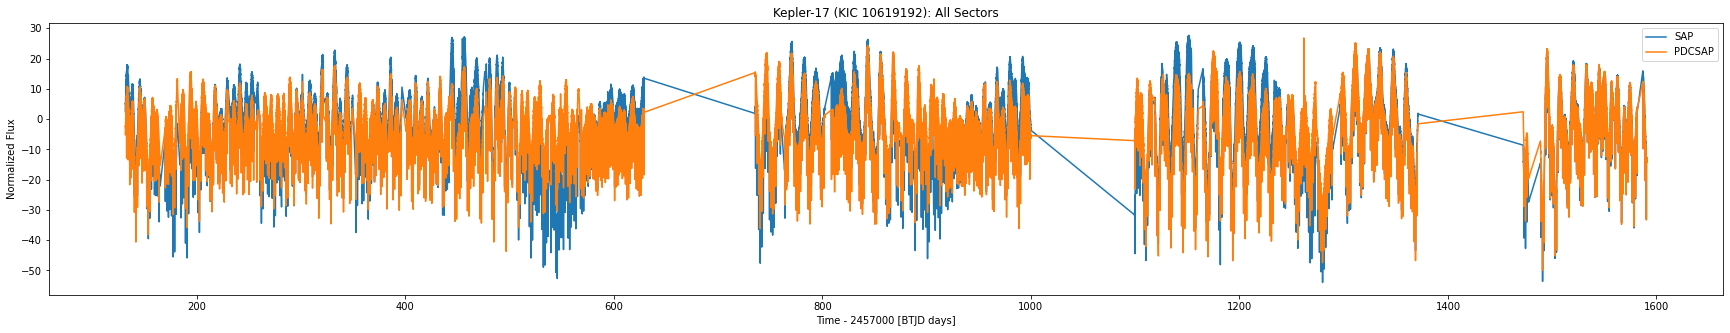

In [ ]:
# Download all available lightcurves and target pixel files for the target
tpf_2mins_all, lcfs_all = download_all(target_id, mission)

# Stitch corrected lightcurves together
sap_lc_all, sap_time_all, sap_flux_all, sap_flux_err = stitch_lightcurves(lcfs_all, tpf_2mins_all, bins=bins, corr="sap")
pdcsap_lc_all, pdcsap_time_all, pdcsap_flux_all, pdcsap_flux_err = stitch_lightcurves(lcfs_all, tpf_2mins_all, bins=bins, corr="pdcsap")
if mission == "TESS":
  reg_lc_all, reg_time_all, reg_flux_all, reg_flux_err = stitch_lightcurves(lcfs_all, tpf_2mins_all, bins=bins, corr="reg")

# For storing plot in Document
document.add_heading("Full lightcurve")
lightcurve_all_plot = BytesIO()

# Plot stitched lightcurves together
plt.figure(figsize=(30,5))
plt.plot(sap_time_all, sap_flux_all, label="SAP")
plt.plot(pdcsap_time_all, pdcsap_flux_all, label="PDCSAP")
if mission == "TESS":
  plt.plot(reg_time_all, reg_flux_all, label="REG")
plt.xlabel("Time - 2457000 [BTJD days]")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title(pl_hostname+" ("+target_id+"): All Sectors")

# Add plot to Document
plt.savefig(lightcurve_all_plot)
document.add_picture(lightcurve_all_plot, width=Inches(7))
lightcurve_all_plot.close()

**Download and stitch selected sectors**

The Gaussian Process will take a very long time to compute if you use all the sectors.<br />
Here, we stitch a lightcurve of only specific sectors or one sector which we will use for the model.<br />
We already set the sectors and bin size, but you can change them again here.

Exposure time: 0.001388888888888889


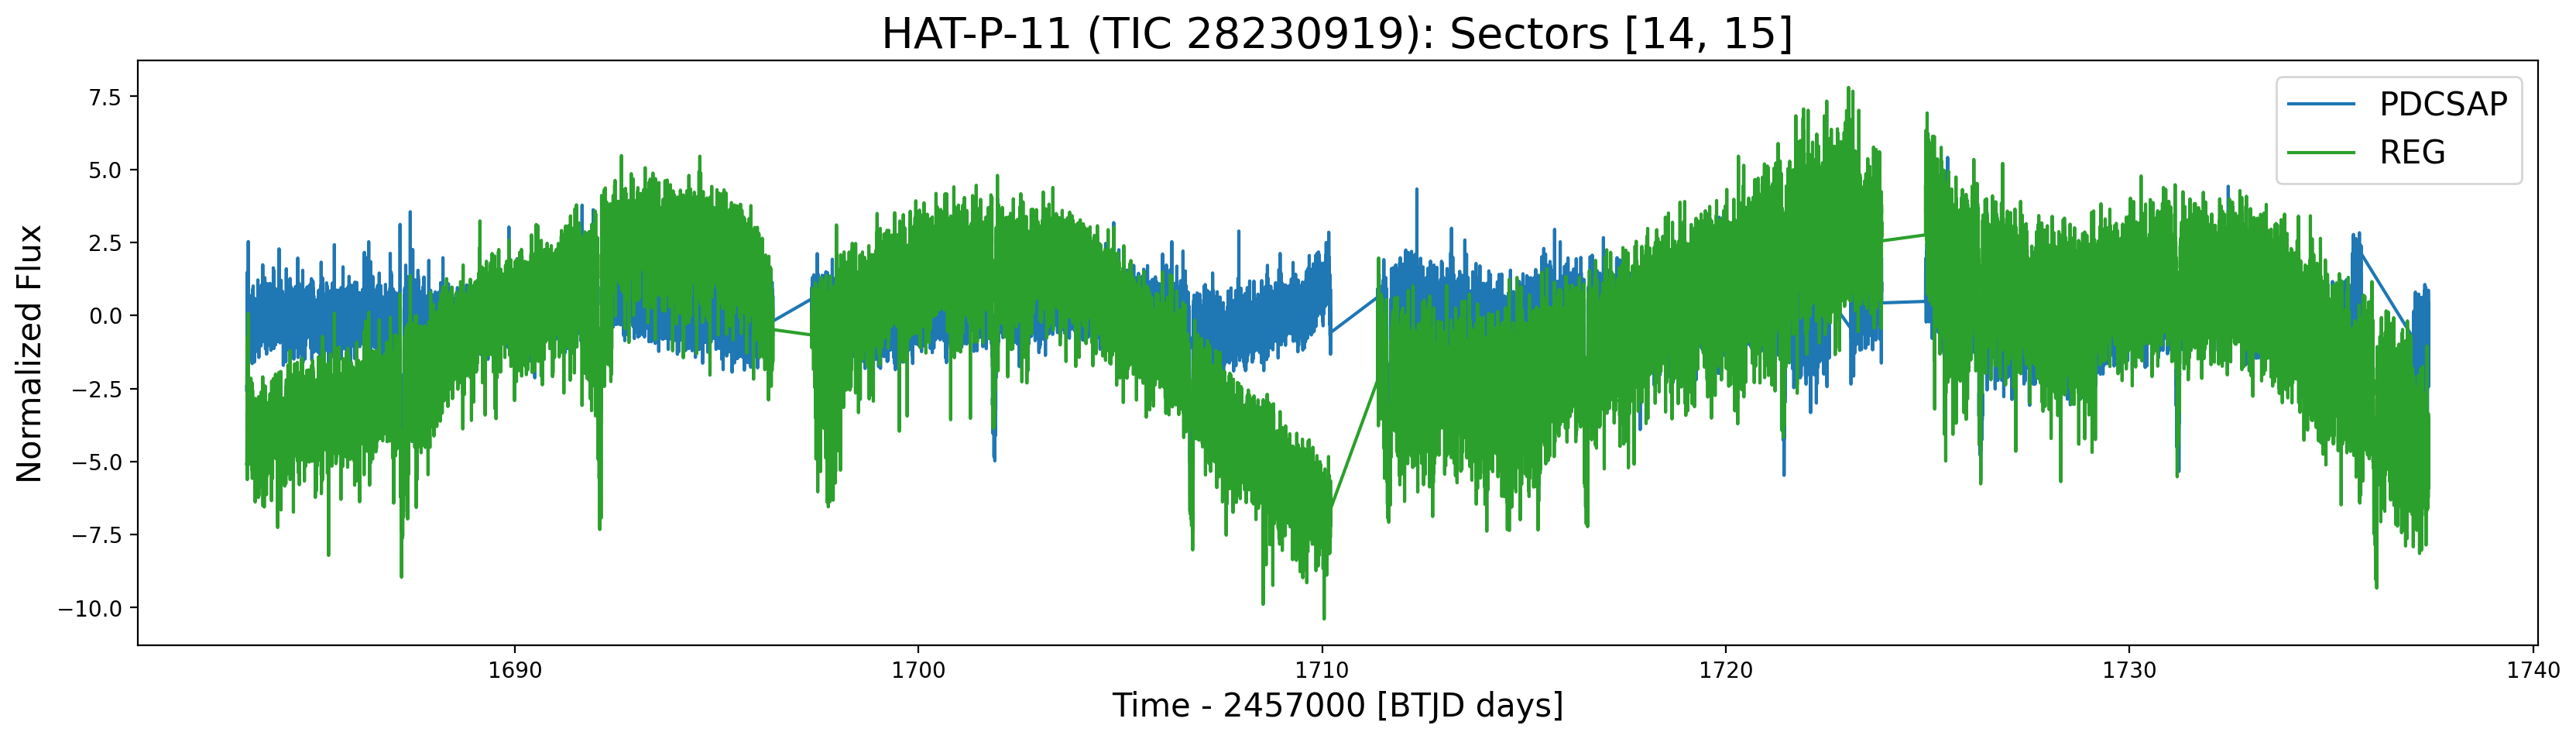

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

sectors = sectors
bins = bins

# Download selected lightcurves and target pixel files for the target
tpf_2mins, lcfs = download_selected(target_id, mission, sectors)

# Select binsize based on mission
if mission == "TESS":
  bins = bins
elif mission == "Kepler":
  bins = bins

# Stitch selected lightcurves together
# "sap", "pdcsap", and "reg" refer to correction methods
sap_lc, sap_time, sap_flux, sap_flux_err = stitch_lightcurves(lcfs, tpf_2mins, bins=bins, corr="sap")
pdcsap_lc, pdcsap_time, pdcsap_flux, pdcsap_flux_err = stitch_lightcurves(lcfs, tpf_2mins, bins=bins, corr="pdcsap")
if mission == "TESS":
  reg_lc, reg_time, reg_flux, reg_flux_err = stitch_lightcurves(lcfs, tpf_2mins, bins=bins, corr="reg")

# For storing plot in Document
document.add_heading("Stitched Lightcurve")
lightcurve_selected_plot = BytesIO()

# Plot selected stitched lightcurves together
plt.figure(figsize=(20,5))
#plt.plot(sap_time, sap_flux, label="SAP", color="C1")
plt.plot(pdcsap_time, pdcsap_flux, label="PDCSAP", color="C0")
if mission == "TESS":
  plt.plot(reg_time, reg_flux, label="REG", color="C2")
plt.xlabel("Time - 2457000 [BTJD days]", fontsize=15)
plt.ylabel("Normalized Flux", fontsize=15)
plt.legend(fontsize=15)
plt.title(pl_hostname+" ("+target_id+"): Sectors "+str(sectors), fontsize=20)

# Add plot to Document
plt.savefig(lightcurve_selected_plot)
document.add_picture(lightcurve_selected_plot,width=Inches(7))
lightcurve_selected_plot.close()

# Get the exposure time of the lightcurve
with lcfs[0].hdu as hdu:
    hdr = hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
print("Exposure time:",texp)

texp = None

**Select corrected lightcurve**

We now have multiple corrected versions of the light and now we have to select the one we want to use for the GP model.<br />
We already set the correction method, but you can change it again here if the figure above shows that there is a better one.

In [ ]:
corr = corr

if corr == "sap":
  lc = sap_lc
  time = sap_time
  flux = sap_flux
  flux_err = sap_flux_err

elif corr == "pdcsap":
  lc = pdcsap_lc
  time = pdcsap_time
  flux = pdcsap_flux
  flux_err = pdcsap_flux_err

elif corr == "reg":
  lc = reg_lc
  time = reg_time
  flux = reg_flux
  flux_err = reg_flux_err

elif corr == "pld":
  lc = pld_lc
  time = pld_time
  flux = pld_flux
  flux_err = pld_flux_err

# Get Initial Estimates

**Transit Search**

Get inital estimates for transit period, reference time, and depth by applying the BoxLeastSquares method to the selected lightcurve.

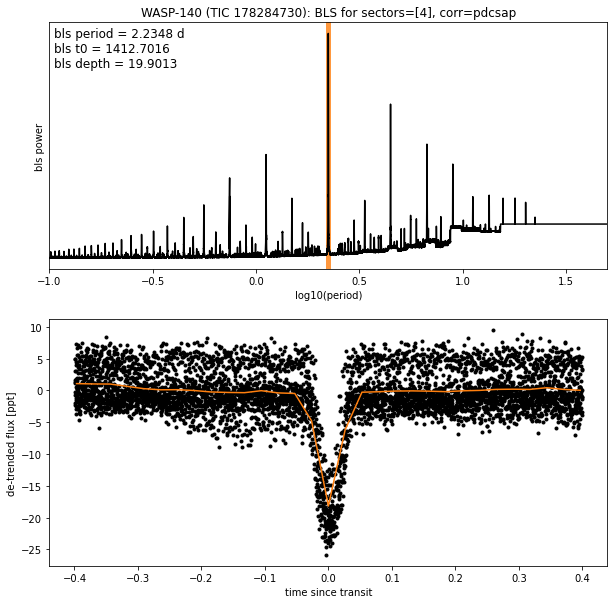

In [ ]:
bls_period, bls_t0, bls_depth = BLS(lc.flatten(), time, flux, sectors=sectors)

Sometimes BoxLeastSquares does not find the planet. The following method uses TransitLeastSquares to find the transit period and then passes that to BoxLeastSquares to get inital estimates for transit period, reference time, and depth.

Searching with limb-darkening estimates using quadratic LD (a,b)= (0.4036, 0.2028)
(0.4036, 0.2028) 0.924 0.108329 0.108329 0.844379 0.0442312 0.0442312
Transit Least Squares TLS 1.0.25 (04 June 2020)


  0%|          | 0/2344 periods | 00:00<?

Creating model cache for 38 durations
Searching 15793 data points, 2344 periods from 0.601 to 12.967 days
Using all 2 CPU threads


100%|██████████| 2344/2344 periods | 01:04<00:00
  0%|          | 0/5680 [00:00<?, ?it/s]

Searching for best T0 for period 2.23499 days


100%|██████████| 5680/5680 [00:02<00:00, 2160.38it/s]


tls period: 2.2349925898870246 period uncertainty: 0.004263686975894743 T0: 1412.701619513527
2.236136431118447 1412.6936201822232 19.810048463388526


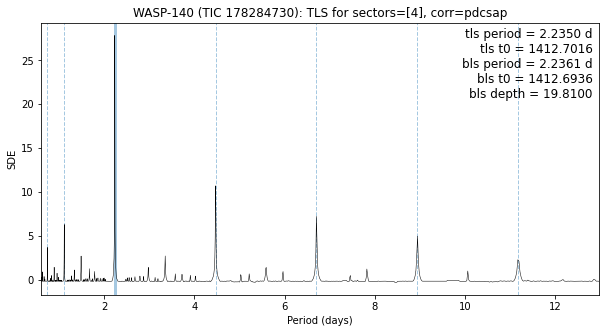

In [ ]:
id_num = int(target_id.split()[1])
bls_period, bls_t0, bls_depth, tls_results = TLS(lc.flatten(), time, flux, id_num, sectors=sectors)

If you are only looking at rotation, mask the transits in the lightcurve.

In [ ]:
from transitleastsquares.helpers import resample, transit_mask

if rot==True and transit==False:
  time, flux = mask_transits(time, flux, tls_results)

**LS Periodogram**

Get initial estimate for stellar rotation period by applying Lomb-Scargle Periodogram to the lightcurve.

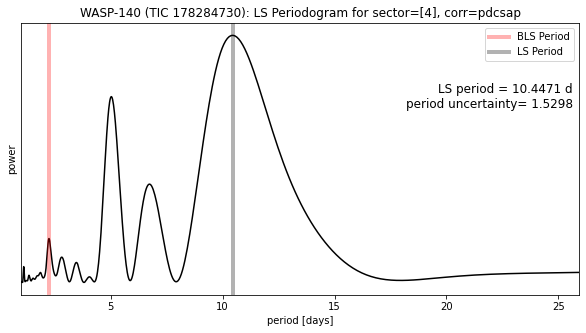

In [ ]:
rot_period_selected = ls_periodogram(time, flux, xlim_min=1, xlim_max=time.max()-time.min(), bls=bls_period, sector=str(sectors))

**Autocorrelation Function**

Just for comparison: check if autocorrelation results are similar to LS Periodogram.

rot. period: 10.873864345747734


10.873864345747734

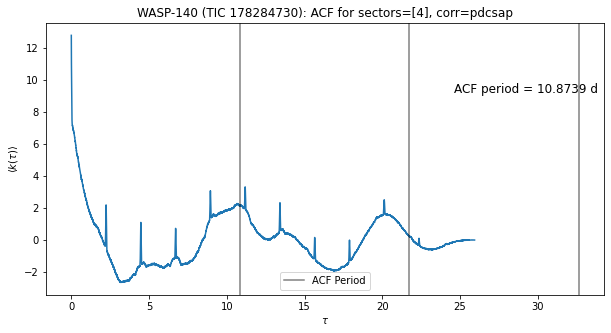

In [ ]:
# Plot autocorrelation function for selected lightcurve
ACF(time, flux, flux_err, sectors=sectors)

# Gaussian Process model

**Build and optimize Gaussian Process model**

In [ ]:
def GP_model(x, y, yerr, init_params, mask=None, start=None, transit=True, rot=True):

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)

        if transit:
          
          print("Defining Transit Model...")

          # Mass and radius of the star
          M_star = init_params['M_star']
          R_star = init_params['R_star']
          BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
          m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
          r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

          # Orbital period of the planet
          logP = pm.Normal("logP", mu=np.log(init_params["bls_period"]), sd=1)
          period = pm.Deterministic("period", tt.exp(logP))

          # Time of first transit
          t0 = pm.Normal("t0", mu=init_params["bls_t0"], sd=1)

          # Radius of the planet
          logr = pm.Normal(
              "logr",
              sd=1.0,
              mu=0.5 * np.log(1e-3 * np.array(init_params["bls_depth"])) + np.log(R_star[0]),
          )
          r_pl = pm.Deterministic("r_pl", tt.exp(logr))
          ror = pm.Deterministic("ror", r_pl / r_star)

          # Impact parameter
          b = xo.distributions.ImpactParameter("b", ror=ror)

          # Eccentricity of orbit
          ecs = xo.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
          ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))

          # Omega of orbit
          omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
          xo.eccentricity.kipping13("ecc_prior", observed=ecc)

          # Create Orbit
          orbit = xo.orbits.KeplerianOrbit(
              r_star=r_star,
              m_star=m_star,
              period=period,
              t0=t0,
              b=b,
              ecc=ecc,
              omega=omega,
          )

          # Limb Darkening coefficients
          u_star = xo.distributions.QuadLimbDark("u_star")

          # Compute limb darkened light curve
          def mean_model(t):
              light_curves = pm.Deterministic(
                  "light_curves",
                  xo.LimbDarkLightCurve(u_star).get_light_curve(
                      orbit=orbit, r=r_pl, t=t, texp=init_params["exposure_time"]
                  )
                  * 1e3,
              )
              return tt.sum(light_curves, axis=-1) + mean
            
        # White noise
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)

        # Granulation kernel
        print("Defining Granulation Kernel...")
        logw0 = pm.Normal("logw0", mu=0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)
        gran_kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))

        # RotationTerm kernel
        if rot:
          print("Defining Rotation Kernel...")
          logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
          BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
          logperiod = BoundedNormal("logperiod", mu=np.log(init_params["rot_period"]), sd=5.0)
          logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
          logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
          mix = xo.distributions.UnitUniform("mix")
          rotperiod = pm.Deterministic("rotperiod", tt.exp(logperiod))
          rot_kernel = xo.gp.terms.RotationTerm(
              log_amp=logamp, period=rotperiod, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
          )

        # Build ExoRotGP, RotGP, or ExoGP model
        if rot and transit:
            print("Defining ExoRotGP...")
            kernel = gran_kernel + rot_kernel
            gp = xo.gp.GP(
                kernel, x[mask],  tt.exp(logs2) + tt.zeros(mask.sum()), mean=mean_model
            )
        if rot and not transit:
            print("Defining RotGP...")
            kernel = rot_kernel
            gp = xo.gp.GP(
                kernel, x[mask],  tt.exp(logs2) + tt.zeros(mask.sum()), mean=mean
            )
        if transit and not rot:
            print("Defining ExoGP...")
            kernel = gran_kernel
            gp = xo.gp.GP(
                kernel, x[mask],  tt.exp(logs2) + tt.zeros(mask.sum()), mean=mean_model
            )

        gp.marginal("gp", observed=y[mask])
        pm.Deterministic("gp_pred", gp.predict())

        # Optimize for Maximum a Posteriori (MAP) parameters
        print("Optimizing model...")

        if start is None:
            start = model.test_point

        if transit:
          map_params = xo.optimize(start=start, vars=[logs2, logSw4, logw0])
        else:
          map_params = xo.optimize(start=start, vars=[logs2])

        if rot:
          map_params = xo.optimize(start=map_params, vars=[logamp, rotperiod, logQ0, logdeltaQ, mix])

        if transit:
          map_params = xo.optimize(start=map_params, vars=[logr])
          map_params = xo.optimize(start=map_params, vars=[b])
          map_params = xo.optimize(start=map_params, vars=[logP, t0])
          map_params = xo.optimize(start=map_params, vars=[u_star])
          map_params = xo.optimize(start=map_params, vars=[logr])
          map_params = xo.optimize(start=map_params, vars=[b])
          map_params = xo.optimize(start=map_params, vars=[ecc, omega])
          map_params = xo.optimize(start=map_params, vars=[mean])
          map_params = xo.optimize(start=map_params, vars=[logs2, logSw4, logw0])

          if rot:
            map_params = xo.optimize(start=map_params, vars=[logamp, rotperiod, logQ0, logdeltaQ, mix])

        else:
          map_params = xo.optimize(start=map_params, vars=[mean])

        map_params = xo.optimize(start=map_params)

    return model, map_params

Set the initial estimates and run the GP model

In [ ]:
# variables: x, y, stellar_params, pl_hostname, bls_period, bls_t0, bls_depth, rot_period

init_params = {
    'M_star': M_star,
    'R_star': R_star,
    'bls_period': bls_period,
    'bls_t0': bls_t0,
    'bls_depth': bls_depth,
    'rot_period': rot_period_selected,
    'exposure_time': texp
}

x = time.astype(float)
y = flux
yerr = flux_err

model0, map_params0 = GP_model(x, y, yerr, init_params, transit=transit, rot=rot)

Defining Transit Model...
Defining Granulation Kernel...
Defining Rotation Kernel...
Defining ExoRotGP...
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Optimizing model...
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/li

optimizing logp for variables: [logw0, logSw4, logs2]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Desired error not necessarily achieved due to precision loss.
logp: -38295.393202227686 -> -32015.627257295804


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Desired error not necessarily achieved due to precision loss.
logp: -32015.627257295804 -> -32015.62653421518


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [logr]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -32015.62653421518 -> -31969.156091306224


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, logr, r_star]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -31969.156091306224 -> -31653.07691105222


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [t0, logP]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -31653.07691105222 -> -31627.575498174305


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [u_star]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -31627.57549817431 -> -31627.295084161768


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [logr]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Desired error not necessarily achieved due to precision loss.
logp: -31627.295084161768 -> -31627.25886481942


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, logr, r_star]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -31627.25886481942 -> -31626.8201203061


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ecs]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -31626.8201203061 -> -31626.11125705059


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [mean]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -31626.11125705059 -> -31626.11125705059


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [logw0, logSw4, logs2]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -31626.11125705059 -> -27843.71798708387


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -27843.71798708387 -> -27833.982916711


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logSw4, logw0, logs2, u_star, ecc_prior_beta, ecc_prior_alpha, ecs, b, logr, t0, logP, r_star, m_star, mean]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Desired error not necessarily achieved due to precision loss.
logp: -27833.982916710997 -> -27712.31192920546


**Plot model results after optimizing**

In [ ]:
# Define variable names
planet_params =["omega","ecc","r_pl","ror","b","t0","period","r_star","m_star"]
rot_params =["logdeltaQ","logQ0","rotperiod","logamp"]
gran_params =["logw0","logSw4","logs2"]

if rot and transit:
    param_names = rot_params + gran_params + planet_params

if rot and not transit:
    param_names = rot_params

if transit and not rot:
    param_names = gran_params + planet_params

In [ ]:
# Display parameters of the Gaussian Process model
display_model_params(map_params0, param_names)

,deltaQ,Q0,rotperiod,amp,w0,Sw4,s2,omega,ecc,r_pl,r_pl_jup,ror,b,t0,period,r_star,m_star
0,7.815837,446.465231,10.130712,3.681857,6.54716,737.341577,1.868625,1.549696,0.066672,0.130178,1.266782,0.15,0.863831,1412.697356,2.23597,0.867852,0.902014


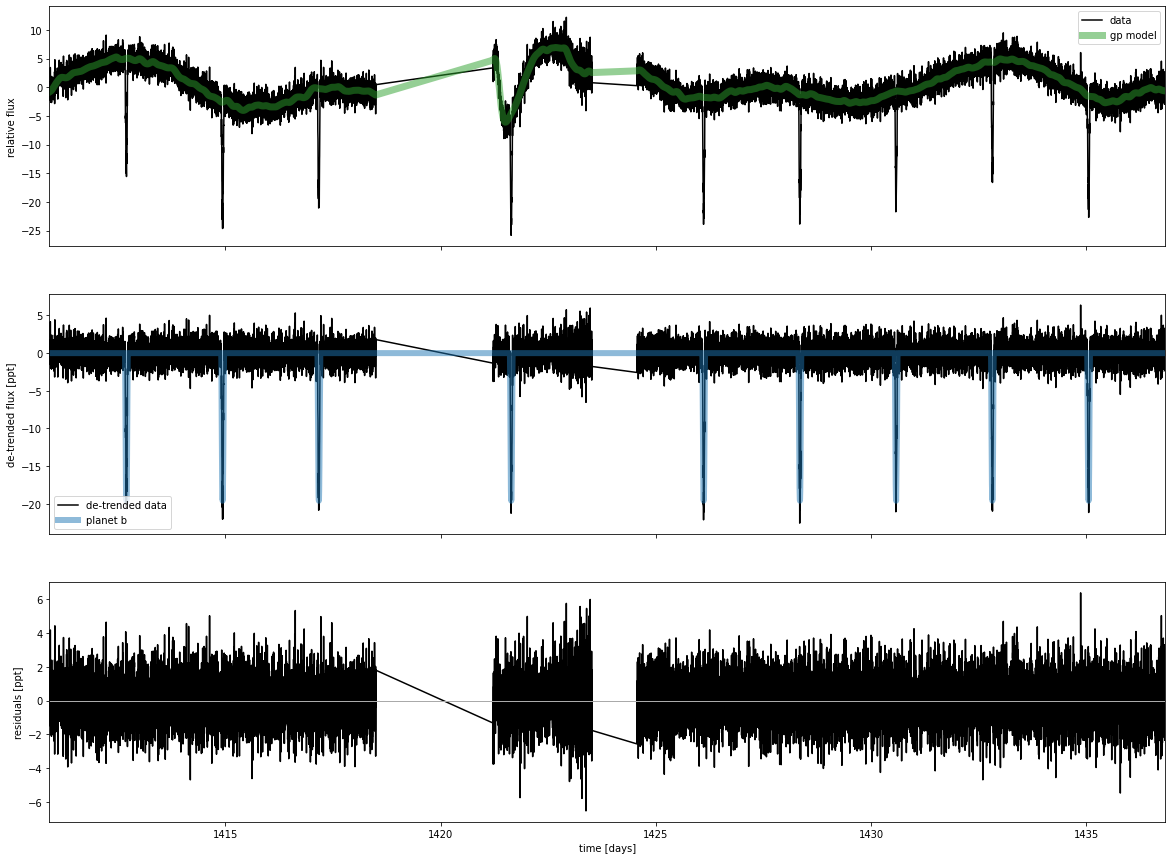

In [ ]:
# Plot the model components: stellar activity (top), transit model (middle), and residuals (bottom)
plot_GP_model(map_params0, transit=transit, rot=rot);

## Clip outliers
Clip outliers based on the residuals of the model.

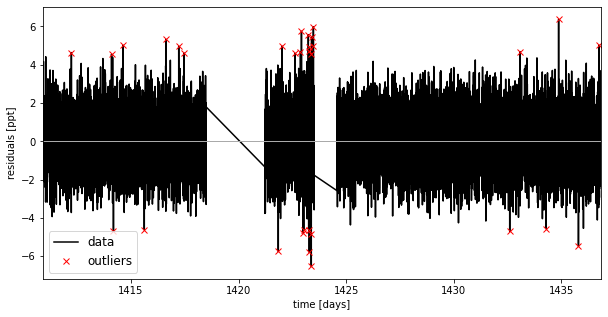

In [ ]:
mask = clip_outliers(x, y, map_params0, rot, transit)

Run the model again without the outliers.

In [ ]:
model, map_params = GP_model(x, y, yerr, init_params, mask=mask, start=map_params0, transit=transit, rot=rot)

Defining Transit Model...
Defining Granulation Kernel...
Defining Rotation Kernel...
Defining ExoRotGP...
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Optimizing model...
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [logw0, logSw4, logs2]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -27446.844557117405 -> -27443.987189022


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -27443.987189022 -> -27443.98712613784


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [logr]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -27443.98712613784 -> -27443.984205530527


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, logr, r_star]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Desired error not necessarily achieved due to precision loss.
logp: -27443.984205530527 -> -27443.982923021278


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [t0, logP]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Desired error not necessarily achieved due to precision loss.
logp: -27443.982923021278 -> -27443.982458411017


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [u_star]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Desired error not necessarily achieved due to precision loss.
logp: -27443.982458411017 -> -27443.982441143216


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [logr]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -27443.982441143216 -> -27443.98244091245


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, logr, r_star]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -27443.98244091245 -> -27443.982431198954


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ecs]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -27443.98243119895 -> -27443.982430905857


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [mean]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -27443.982430905857 -> -27443.982382893966


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [logw0, logSw4, logs2]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -27443.982382893966 -> -27443.982374906358


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Optimization terminated successfully.
logp: -27443.982374906358 -> -27443.982374320545


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logSw4, logw0, logs2, u_star, ecc_prior_beta, ecc_prior_alpha, ecs, b, logr, t0, logP, r_star, m_star, mean]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']



message: Desired error not necessarily achieved due to precision loss.
logp: -27443.982374320545 -> -27443.982374320407


In [ ]:
# Display parameters of the Gaussian Process model
display_model_params(map_params, param_names)

,deltaQ,Q0,rotperiod,amp,w0,Sw4,s2,omega,ecc,r_pl,r_pl_jup,ror,b,t0,period,r_star,m_star
0,7.785494,457.13055,10.130267,3.66895,6.499983,722.205513,1.818538,1.549668,0.066676,0.130089,1.265921,0.149944,0.863784,1412.697351,2.23597,0.867587,0.902014


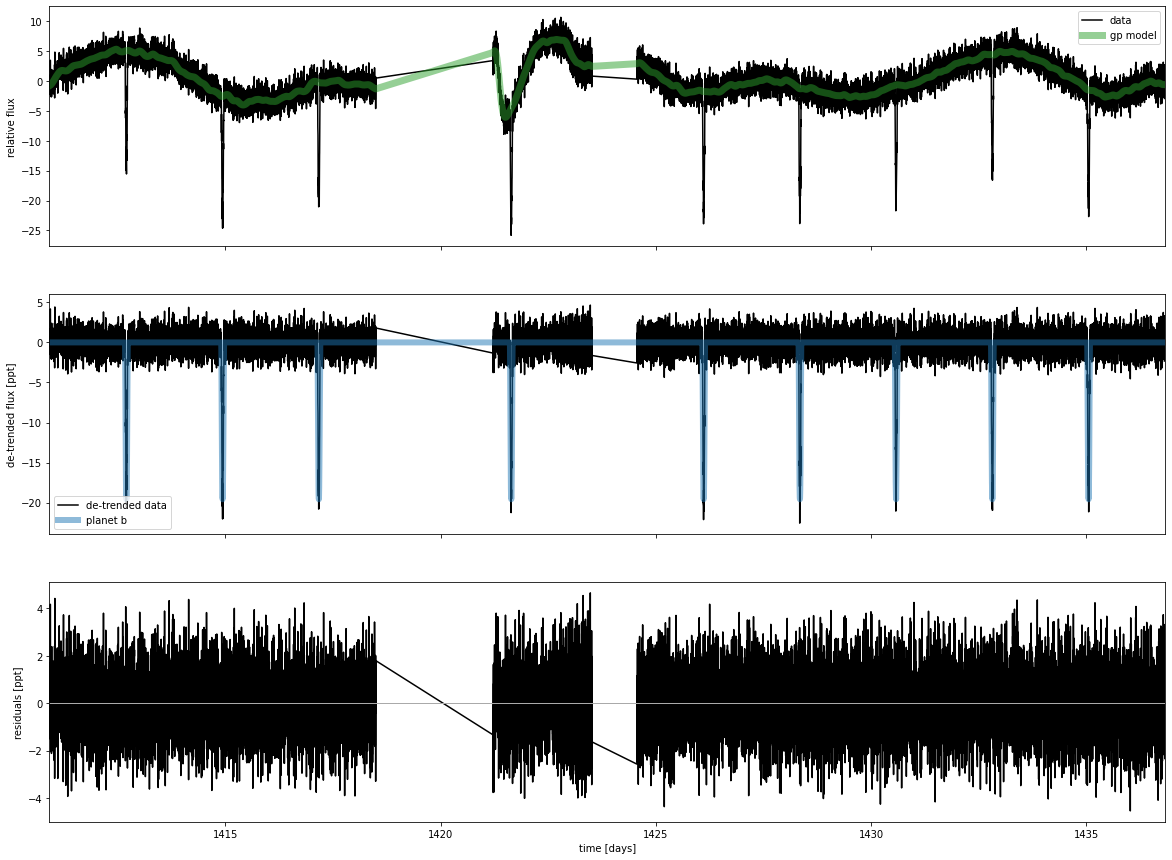

In [ ]:
# Plot the model components: stellar activity (top), transit model (middle), and residuals (bottom)
plot_GP_model(map_params, mask, transit=transit, rot=rot);

# MCMC

If the results above look promising, you can pass the Gaussian process model and the MAP parameters to MCMC.<br />
We already set the MCMC conditions but you change them again here.

In [ ]:
from datetime import datetime

mcmc_tune = mcmc_tune
mcmc_samples = mcmc_samples
mcmc_chains = mcmc_chains

before = datetime.now()

np.random.seed(42)

# Run MCMC
with model:
    trace = pm.sample(
        tune=mcmc_tune,
        draws=mcmc_samples,
        start=map_params,
        cores=2,
        chains=mcmc_chains,
        step=xo.get_dense_nuts_step(target_accept=0.95),
    )

# Store computation time of MCMC sampling
after = datetime.now()
duration = after - before
duration_in_s = duration.total_seconds()
duration_in_m = divmod(duration_in_s, 60) 
print("Computation Time:",duration_in_m)

document.add_heading("Computation Time: "+str(duration_in_m))

['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logSw4, logw0, logs2, u_star, ecc_prior_beta, ecc_prior_alpha, ecs, b, logr, t0, logP, r_star, m_star, mean]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


Sampling 2 chains: 100%|██████████| 4700/4700 [2:04:57<00:00,  1.60s/draws]


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.6/dist-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Computation Time: (126.0, 10.137846999999965)


# Results

**Summary table** <br />
Display and save a table with summary statistics for our MCMC samples.<br />
These will tell you if the MCMC converged.
*   **neff**: refers to the number of effective samples
*   **rhat**: refers to the Gelman-Rhubin statistic (we want this to be below 1.1)



In [ ]:
if transit:
  param_names = param_names+["u_star","mean"]

# Store samples for each parameter in dataframe
samples = pm.trace_to_dataframe(trace, varnames=param_names)

# Save samples
samples.to_pickle("./samples_"+gp_type+"_"+pl_hostname+"_"+str(sectors)+"_"+corr+".pkl")

# Create summary table with statistics
summary = pm.summary(
    trace,
    var_names=param_names,
)

# Add summary table to Document
df = summary
document.add_heading("Summary Statistics")
t = document.add_table(df.shape[0]+1, df.shape[1]+1)
for j in range(1,df.shape[-1]+1):
    t.cell(0,j).text = df.columns[j-1]
for j in range(1,df.shape[0]+1):
    t.cell(j,0).text = df.index[j-1]
for i in range(df.shape[0]):
    for j in range(df.shape[-1]):
        t.cell(i+1,j+1).text = str(df.values[i,j].round(6))

# Save summary table
with open(gp_type+'_summary_'+pl_hostname+'_'+str(sectors)+"_"+corr+".pkl", 'wb') as handle:
    pickle.dump(summary, handle)

summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logdeltaQ,2.759102,9.890568,1.604665e-01,-16.917488,21.910805,3545.356945,1.000176
logQ0,10.117538,5.756573,1.201742e-01,1.905575,21.811012,1880.653995,0.999818
rotperiod,10.150563,0.138334,2.137513e-03,9.872928,10.409860,3915.573451,0.999779
logamp,1.611501,0.871652,1.404046e-02,0.042866,3.343938,3904.754149,0.999750
logw0,1.835893,0.097737,1.491160e-03,1.639785,2.020975,4664.797894,0.999895
logSw4,6.559591,0.176997,2.292399e-03,6.206394,6.892331,5258.384046,0.999919
logs2,0.598512,0.011050,1.454511e-04,0.577063,0.619937,5472.353766,0.999762
omega,0.814518,1.668232,3.989396e-02,-2.938483,3.132711,2070.448736,0.999750
ecc,0.132452,0.105980,4.568465e-03,0.000296,0.354868,425.216033,1.007078
r_pl,0.129924,0.007748,3.029647e-04,0.116064,0.146597,424.525853,1.000105


**Results table**<br />
Calculate the mean and the quantiles (15, 84) of each parameter based on the samples.<br />
Display and save a table which shows the mean and uncertainty estimate of each parameter in comparison with the literature values.

In [ ]:
# Calculate mean and quantiles for parameters
statistics, var_names = get_statistics(samples, transit=transit)

# Create results table
star = targets[(targets['hostname']==pl_hostname)]
results = results_table(statistics, star, var_names)
display(results)

# Add results table to Document
document.add_heading("Results")
df = results
t = document.add_table(df.shape[0]+1, df.shape[1])
for j in range(df.shape[-1]):
    t.cell(0,j).text = df.columns[j]
for i in range(df.shape[0]):
    for j in range(df.shape[-1]):
        t.cell(i+1,j).text = str(df.values[i,j])

# Save results table
with open(gp_type+'_results_'+pl_hostname+'_'+str(sectors)+"_"+corr+".pkl", 'wb') as handle:
    pickle.dump(results, handle)

,param,gp_mean,gp_error,ref_mean,ref_error,ref_name
0,deltaQ,15.78566,"(26972.14458, 21253.27432)",,,
1,Q0,24773.70218,"(59.97371, 1400.87456)",,,
2,rotperiod,10.15056,"(0.12184, 0.13158)",10.229,"(1.217, 1.217)",Martins et al.
3,amp,5.01033,"(2.13111, 2.65037)",,,
4,w0,6.27073,"(1.10973, 1.1009)",,,
5,Sw4,705.98303,"(1.20083, 1.19205)",,,
6,s2,1.81941,"(1.0118, 1.0109)",,,
7,omega,0.81452,"(1.2899, 1.72445)",,,
8,ecc,0.13245,"(0.07177, 0.1271)",0.047,"(0.0035, 0.0035)",Hellier et al. 2017
9,r_pl_jup,1.26427,"(0.06685, 0.07308)",1.44,"(0.18, 0.42)",Hellier et al. 2017


Visualize the parameter results to compare the estimates of the GP model with those from literature.

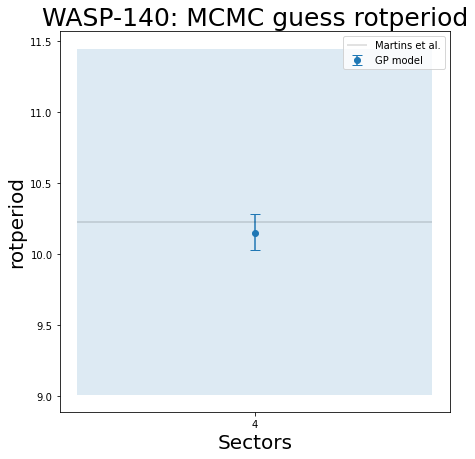

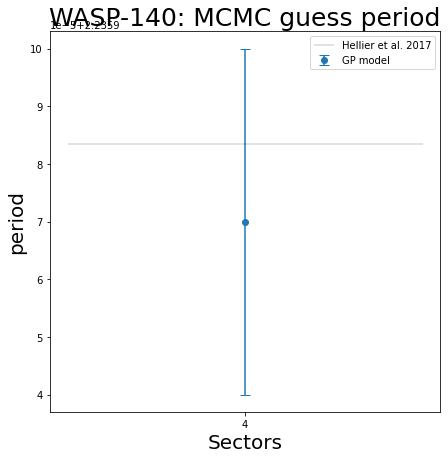

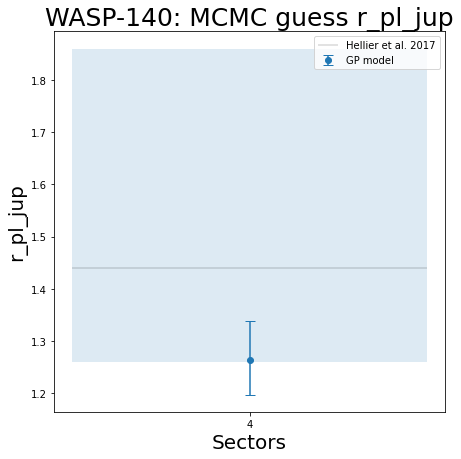

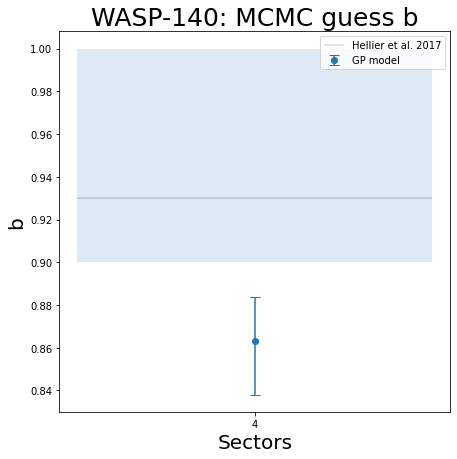

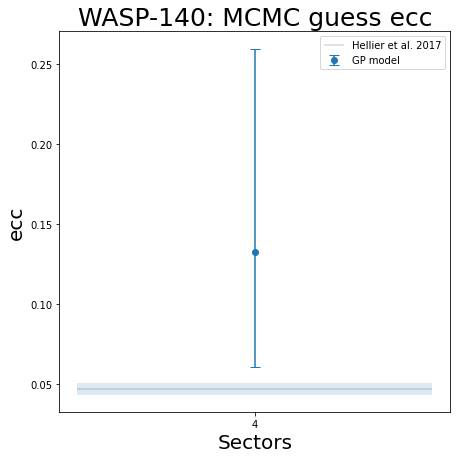

In [ ]:
document.add_heading("Parameter Plots")

if rot:
  print_error_bars(results, "rotperiod", sectors)
if transit:
  print_error_bars(results, "period", sectors)
  print_error_bars(results, "r_pl_jup", sectors)
  print_error_bars(results, "b", sectors)
  print_error_bars(results, "ecc", sectors)

**Residual Analysis**<br />
Plot the model components and a histogram of the residuals.

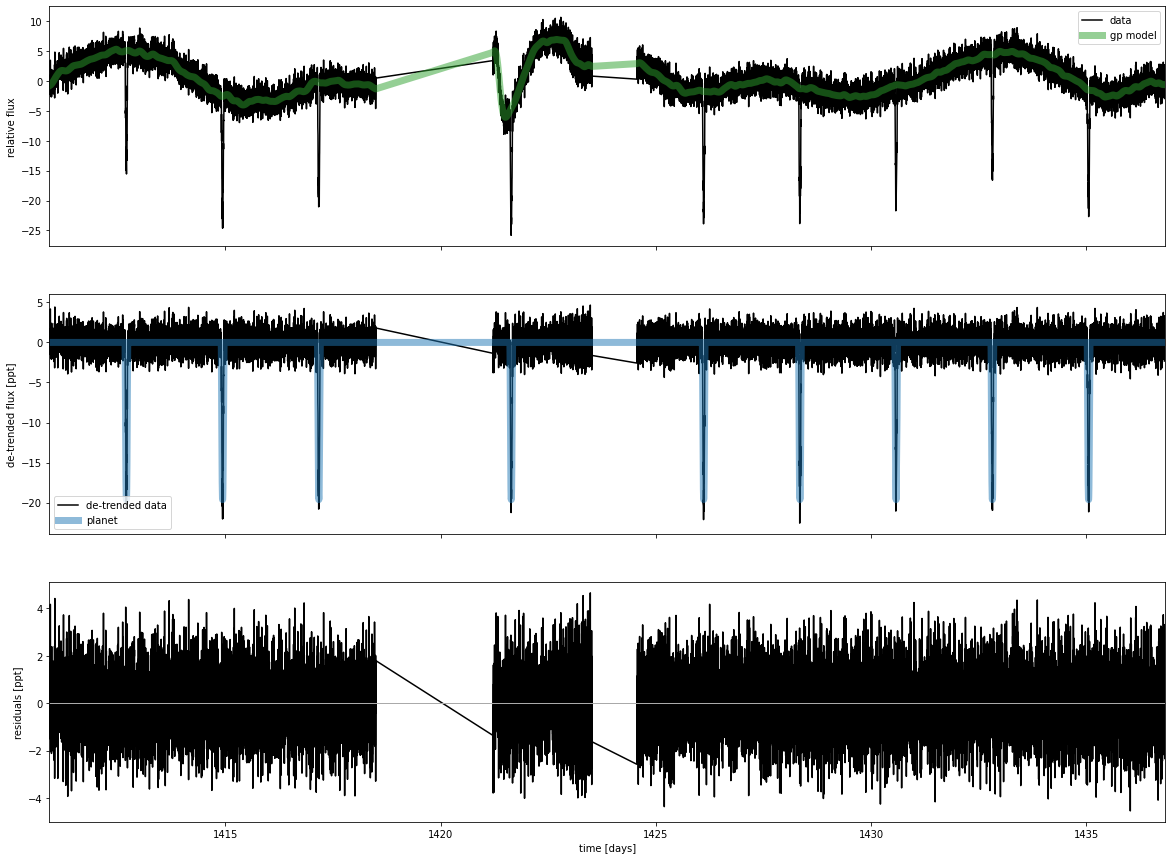

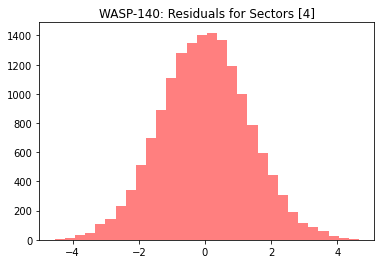

In [ ]:
# Get stellar activity, lightcurve, and residual components of model
model_components = get_model_components(trace, mask, transit=transit, rot=rot)

# Save model components
with open(gp_type+'_model_components_'+pl_hostname+'_'+str(sectors)+'_'+corr+'.pckl', 'wb') as b:
    pickle.dump(model_components,b)

# For storing plot in Document
document.add_heading("Residuals")
residuals_plot = BytesIO()

# Examine histogram of residuals to see if they have a Gaussian distribution
num_bins = 30
plt.figure()
n, bins, patches = plt.hist(model_components['residuals'], num_bins, facecolor='red', alpha=0.5)
plt.title(pl_hostname + ": Residuals for Sectors " + str(sectors))

# Add plot to Document
plt.savefig(residuals_plot)
document.add_picture(residuals_plot, width=Inches(7))
residuals_plot.close()

**Corner plots**<br />
Visualize the parameters using corner plots.

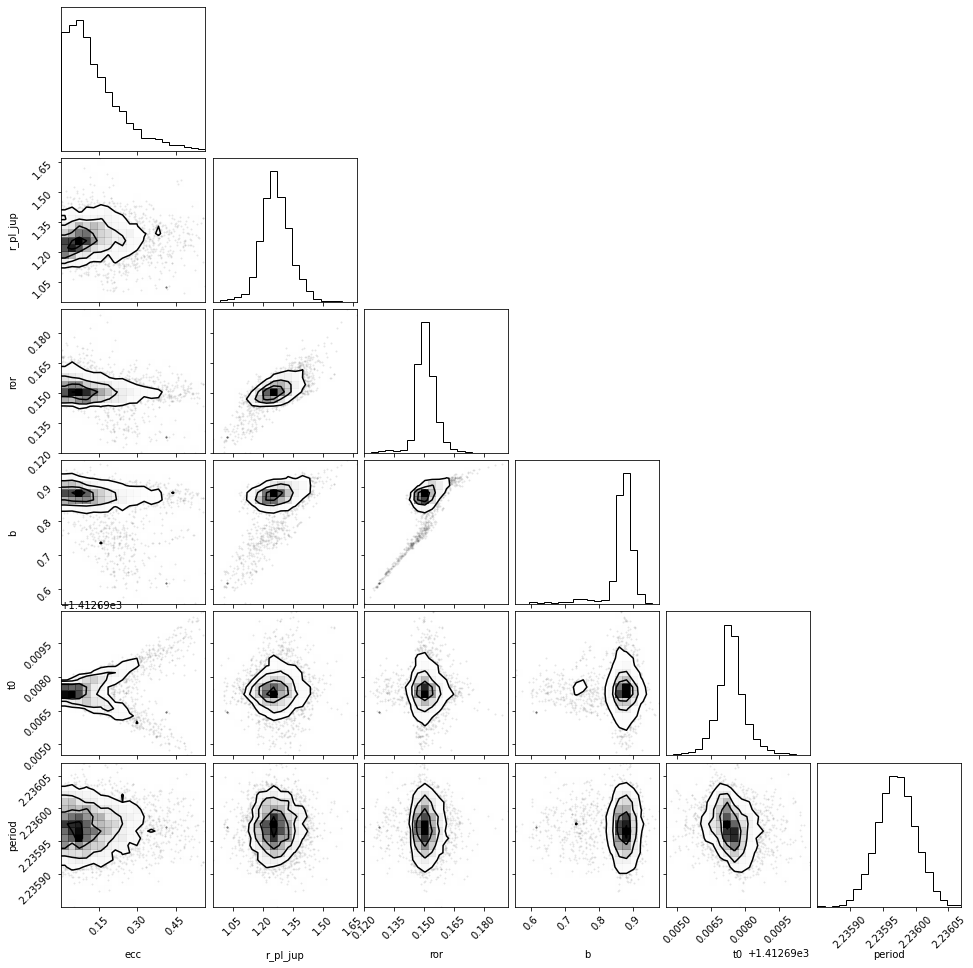

In [ ]:
document.add_heading("Corner Plots")

if transit:

  planet_corner_plot = BytesIO()

  # Convert the radius to Jupiter radii
  samples["r_pl_jup"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_jup).value
  corner.corner(
      samples[["ecc","r_pl_jup","ror","b","t0","period"]],
      labels=["ecc","r_pl_jup","ror","b","t0","period"],
  ).savefig(planet_corner_plot)

  document.add_picture(planet_corner_plot,width=Inches(7))
  planet_corner_plot.close()

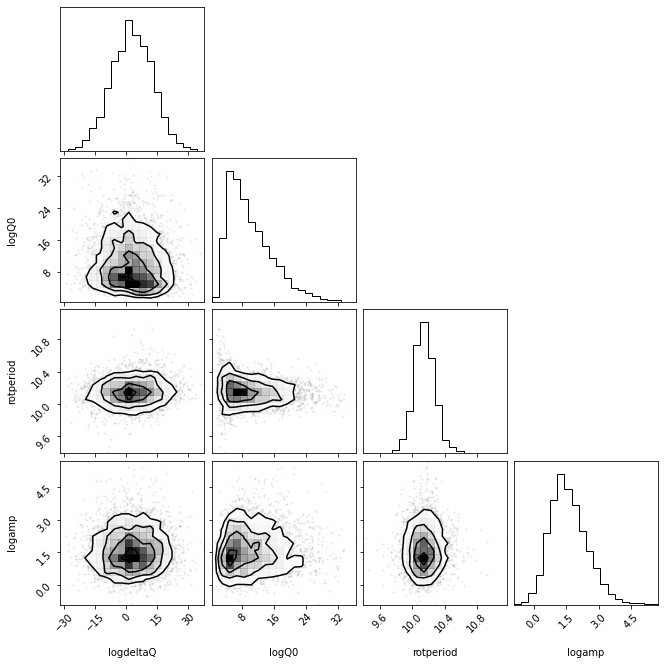

In [ ]:
if rot:

  rot_corner_plot = BytesIO()

  corner.corner(
      samples[rot_params],
      labels=rot_params,
  ).savefig(rot_corner_plot)

  document.add_picture(rot_corner_plot,width=Inches(7))
  rot_corner_plot.close()

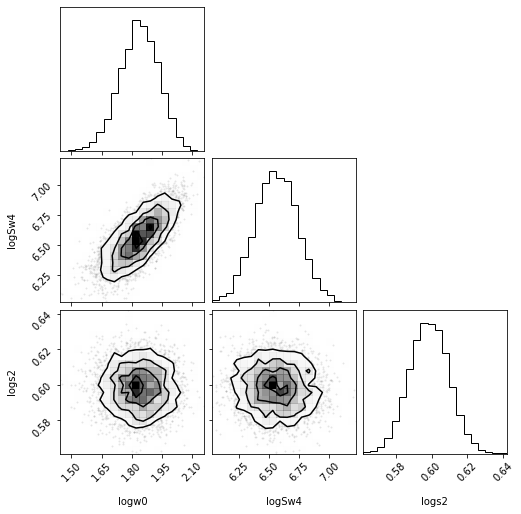

In [ ]:
if transit:

  gran_corner_plot = BytesIO()

  corner.corner(
      samples[gran_params],
      labels=gran_params,
  ).savefig(gran_corner_plot)
  document.add_picture(gran_corner_plot,width=Inches(7))
  gran_corner_plot.close()

Finally, save all the plots and tables in the document.

In [ ]:
document.save(pl_hostname+'_'+str(sectors)+'_'+gp_type+'_'+corr+'.docx')